In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import random

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np 
from typing import List, Tuple
from flwr.common import Metrics
import ray
#https://medium.com/mlearning-ai/evaluating-federated-learning-from-felt-labs-on-mnist-dataset-cbe081b28786
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()

#https://medium.com/mlearning-ai/evaluating-federated-learning-from-felt-labs-on-mnist-dataset-cbe081b28786


2024-02-13 00:12:31.098454: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 00:12:31.124443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 00:12:31.124493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 00:12:31.125366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 00:12:31.129657: I tensorflow/core/platform/cpu_feature_guar

# Data Processing

In [2]:
def getMnistData():
    (traindataset,testDataset),datasetinfo = tfds.load(
        'mnist',
        split=['train','test'],
        shuffle_files= True,
        as_supervised= True,
        with_info= True
    )
    return traindataset,testDataset,datasetinfo

In [3]:
def dataset_to_numpy(dataset):
    features = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        features.append(image)
        labels.append(label)
    return np.array(features), np.array(labels)

def Splitset(intrain,intest):
    Train_images, Train_label = dataset_to_numpy(intrain)
    Test_images, Test_label = dataset_to_numpy(intest)
    return  Train_images, Train_label,Test_images, Test_label

def datanorm(data):
    return data/255 

In [4]:
def split_intoPartition(data, num_partitions):
    #random.shuffle(data)
    # Calculate the size of each partition
    partition_size = len(data) // num_partitions
    # Split the dataset into partitions
    partitions = [data[i * partition_size:(i + 1) * partition_size] for i in range(num_partitions)]
    return partitions    

In [5]:
trainset,testset, info = getMnistData()
Train_images, Train_label,Test_images, Test_label = Splitset(trainset,testset)
Train_images_n = datanorm(Train_images)
Test_images_n = datanorm(Test_images)

2024-02-13 00:12:32.535640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 00:12:32.535993: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 00:12:32.536127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

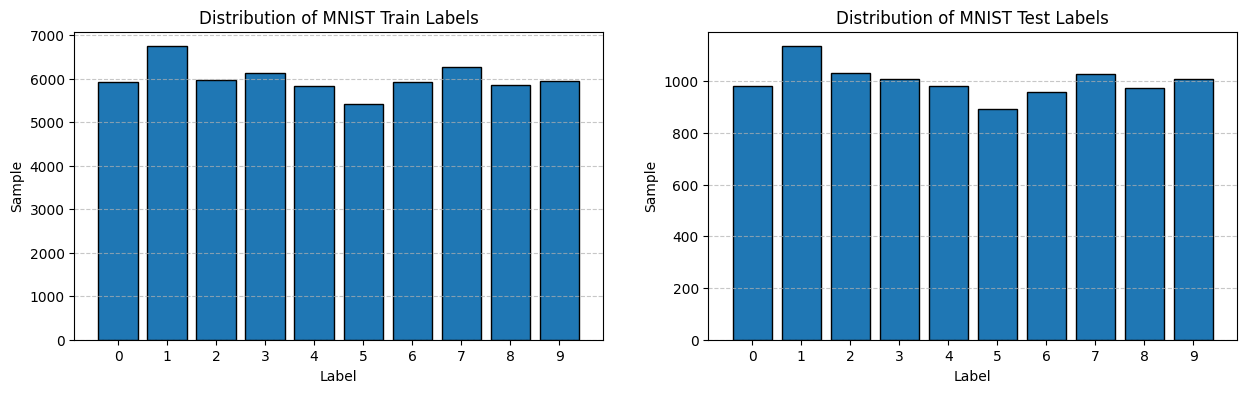

In [6]:
fig_1,axs_1 = plt.subplots(1,2,figsize = (15,4))
axs_1[0].hist(Train_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[0].set_title('Distribution of MNIST Train Labels')
axs_1[0].set_xlabel('Label')
axs_1[0].set_ylabel('Sample')
axs_1[0].set_xticks(range(10))  # Digits 0 to 9
axs_1[0].grid(axis='y', linestyle='--', alpha=0.7)

axs_1[1].hist(Test_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[1].set_title('Distribution of MNIST Test Labels')
axs_1[1].set_xlabel('Label')
axs_1[1].set_ylabel('Sample')
axs_1[1].set_xticks(range(10))  # Digits 0 to 9
axs_1[1].grid(axis='y', linestyle='--', alpha=0.7)


# Partition DataSet

In [7]:
NumOfPartition = 2
train_image_part = split_intoPartition(Train_images_n,NumOfPartition)
train_label_part = split_intoPartition(Train_label,NumOfPartition)

# train_image_part,train_label_part,test_image_part,test_label_part

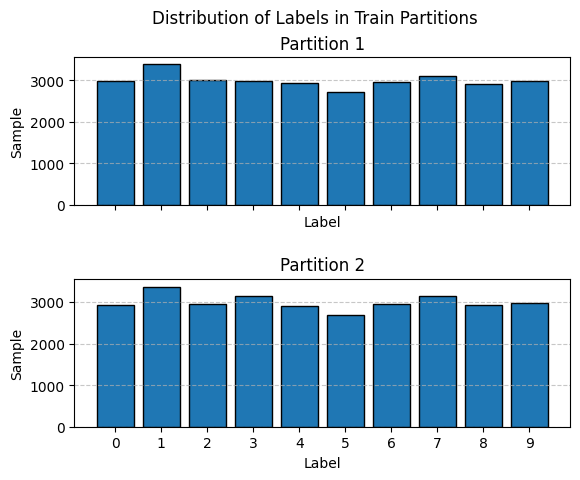

In [8]:
# Plot histogram for each partition
fig, axs = plt.subplots(NumOfPartition, sharex=True, sharey=True)

for i, partition in enumerate(train_label_part):
    axs[i].hist(partition, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black')
    axs[i].set_title(f'Partition {i + 1}')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Sample')
    axs[i].set_xticks(range(10))
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Labels in Train Partitions')
plt.show()

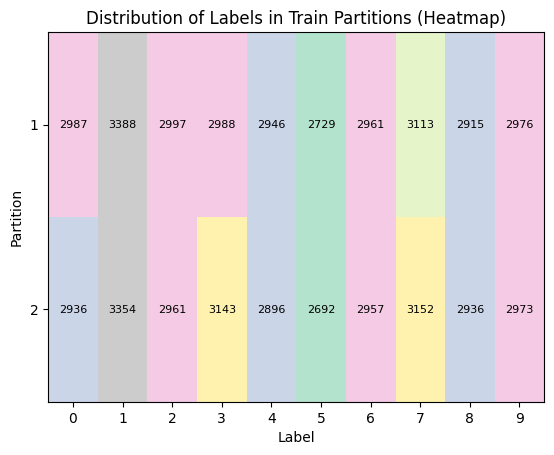

In [9]:
# Create an array to store the histogram data for each partition
hist_data = [np.histogram(partition, bins=range(11))[0] for partition in train_label_part]

# Plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(hist_data, cmap='Pastel2',aspect='auto', interpolation='none')

# Add annotations
for i in range(len(train_label_part)):
    for j in range(10):
        text = ax.text(j, i, hist_data[i][j], ha='center', va='center', color='black', fontsize=8)

# Set labels and ticks
ax.set_title('Distribution of Labels in Train Partitions (Heatmap)')
ax.set_xlabel('Label')
ax.set_ylabel('Partition')
ax.set_xticks(range(10))
ax.set_yticks(range(len(train_label_part)))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(1, len(train_label_part) + 1))

# Add colorbar
plt.colorbar(im, ax=ax).remove()

plt.show()

In [10]:
def simpleRNNModel():
    model = keras.Sequential()    
    model.add(keras.layers.LSTM(128, input_shape=(28, 28)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10,activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss= "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Client

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, train_x,train_y,val_x,val_y, model) -> None:
        super().__init__()
        self.train_feature_set = train_x
        self.train_label_set = train_y
        self.val_feature_set = val_x
        self.val_label_set = val_y
        self.model = model
        
    def get_parameters(self, config):
        return self.model.get_weights()
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print(f"round :{config['current_round']}")
        print(f"Train :{len(self.train_feature_set)}")
        print(f"Test :{len(self.val_feature_set)}")

        # Train the returned model
        TrainHistory = self.model.fit(x=self.train_feature_set, 
                                 y=self.train_label_set,
                                 verbose=2, 
                                 batch_size=config['batch_size'],
                                 epochs=config['local_epochs'],
                                 validation_data =(self.val_feature_set,self.val_label_set)
                                 )
        result ={
                "loss": TrainHistory.history['loss'][-1],
                "accuracy": round(TrainHistory.history['accuracy'][-1]*100,2),
                "val_loss" : TrainHistory.history['val_loss'][-1],
                "val_accuracy"  : round(TrainHistory.history["val_accuracy"][-1]*100,2),
        }

        print("Client Train and validate Done!!!")       
        # Send local model to server to do aggreation
        return self.model.get_weights(), len(self.train_feature_set),result

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # Test Global model
        loss, accuracy = self.model.evaluate(self.val_feature_set,
                                        self.val_label_set,
                                        batch_size=config['batch_size'],
                                        verbose=2)
        print("Global Validate Done!!!")       
        return loss, len(self.val_feature_set), {"accuracy": round(float(accuracy*100),2)}


def generate_client_fn(train_x,train_y,val_x,val_y, model):
    """Return a function to construct a FlowerClient."""

    def client_fn(cid: str):
        print
        return FlowerClient(train_x[int(cid)],train_y[int(cid)],val_x,val_y,model)
    return client_fn


# Server

In [12]:
# config for Client using Server side
def fit_config(server_round: int):
    """Return training configuration dict for each round."""
    config = {
        "batch_size": 32,
        "current_round": server_round,
        "local_epochs": 50,
    }
    return config

def evalute_config(server_round: int):
    """Return test configuration dict for each round."""
    config = {
        "batch_size": 1,
        "current_round": server_round,
    }
    return config

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def fit_average(metric):
    examples = [num_examples for num_examples, _ in metric]
    trainacc = [num_examples * m["accuracy"] for num_examples, m in metric]
    valacc = [num_examples * m["val_accuracy"] for num_examples, m in metric]
    
    return { "example": sum(examples),
            "accuracy": sum(trainacc) / sum(examples),
            "valacc": sum(valacc) / sum(examples)
            }





In [13]:
Fedavgconfig = fl.server.strategy.FedAvg(on_fit_config_fn=fit_config,
                                         on_evaluate_config_fn=evalute_config,
                                         evaluate_metrics_aggregation_fn=weighted_average,
                                         fit_metrics_aggregation_fn=fit_average,
                                         min_evaluate_clients= NumOfPartition,
                                         min_fit_clients=NumOfPartition,
                                         min_available_clients=NumOfPartition,
                                        )

# Simulation

In [14]:
globalmodel = simpleRNNModel()
clientfn = generate_client_fn(train_image_part,train_label_part,Test_images_n,Test_label,globalmodel)


2024-02-13 00:12:38.700908: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [15]:
history = fl.simulation.start_simulation(
        client_fn=clientfn,
        num_clients=NumOfPartition,
        config=fl.server.ServerConfig(num_rounds=10),
        strategy=Fedavgconfig,
        ray_init_args ={
            "include_dashboard": True, # we need this one for tracking,
        },
        actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth # <-- To be executed upon actor init.
    },
        client_resources = {'num_cpus': 8, 'num_gpus': 1}, # A Python dict specifying CPU/GPU resources
    )

INFO flwr 2024-02-13 00:12:38,878 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-13 00:12:40,621	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2024-02-13 00:12:41,323 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 7862388327.0, 'CPU': 16.0, 'object_store_memory': 3931194163.0, 'node:__internal_head__': 1.0, 'node:127.0.1.1': 1.0, 'accelerator_type:G': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7862388327.0, 'CPU': 16.0, 'object_store_memory': 3931194163.0, 'node:__internal_head__': 1.0, 'node:127.0.1.1': 1.0, 'accelerator_type:G': 1.0, 'GPU': 1.0}
INFO flwr 2024-02-13 00:12:41,324 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize you

(DefaultActor pid=31478) round :1
(DefaultActor pid=31478) Train :30000
(DefaultActor pid=31478) Test :10000


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) Epoch 1/50


(DefaultActor pid=31478) 2024-02-13 00:12:44.361353: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
(DefaultActor pid=31478) 2024-02-13 00:12:44.425968: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb05c2d44f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(DefaultActor pid=31478) 2024-02-13 00:12:44.426004: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
(DefaultActor pid=31478) 2024-02-13 00:12:44.430072: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
(DefaultActor pid=31478) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(DefaultActor pid=31478) I0000 00:00:1707801164.495539   31626 device_compiler.h:186] Compiled cluster using XLA!  This line i

(DefaultActor pid=31478) 938/938 - 4s - loss: 0.5078 - accuracy: 0.8340 - val_loss: 0.2208 - val_accuracy: 0.9310 - 4s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.1638 - accuracy: 0.9506 - val_loss: 0.1375 - val_accuracy: 0.9564 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.1113 - accuracy: 0.9660 - val_loss: 0.1019 - val_accuracy: 0.9684 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0849 - accuracy: 0.9741 - val_loss: 0.0800 - val_accuracy: 0.9753 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0689 - accuracy: 0.9794 - val_loss: 0.0802 - val_accuracy: 0.9747 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0578 - accuracy: 0.9820 - val_loss: 0.0792 - val_accuracy: 0.9771 - 2s/epoch - 2ms/step
(Def

(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) Epoch 1/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.5009 - accuracy: 0.8346 - val_loss: 0.1907 - val_accuracy: 0.9434 - 3s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.1536 - accuracy: 0.9535 - val_loss: 0.1404 - val_accuracy: 0.9546 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.1059 - accuracy: 0.9676 - val_loss: 0.1217 - val_accuracy: 0.9632 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0796 - accuracy: 0.9756 - val_loss: 0.0931 - val_accuracy: 0.9719 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0642 - accuracy: 0.9802 - val_loss: 0.0822 - val_accuracy: 0.9754 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0574 - accuracy: 0.9825 - val_loss: 0.0715 - val_accurac

DEBUG flwr 2024-02-13 00:16:48,810 | server.py:236 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:16:48,814 | server.py:173 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 1: strategy sampled 2 clients (out of 2)
(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.0784 - val_accuracy: 0.9815 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Client Train and validate Done!!!
(DefaultActor pid=31478) 10000/10000 - 11s - loss: 0.0784 - accuracy: 0.9801 - 11s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 00:17:10,292 | server.py:187 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:17:10,293 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 2)


(DefaultActor pid=31478) 10000/10000 - 10s - loss: 0.0784 - accuracy: 0.9801 - 10s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!
(DefaultActor pid=31478) round :2
(DefaultActor pid=31478) Train :30000
(DefaultActor pid=31478) Test :10000
(DefaultActor pid=31478) Epoch 1/50


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 4s - loss: 0.0313 - accuracy: 0.9912 - val_loss: 0.0470 - val_accuracy: 0.9863 - 4s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0157 - accuracy: 0.9950 - val_loss: 0.0470 - val_accuracy: 0.9854 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0094 - accuracy: 0.9968 - val_loss: 0.0489 - val_accuracy: 0.9865 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0107 - accuracy: 0.9967 - val_loss: 0.0515 - val_accuracy: 0.9866 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.0615 - val_accuracy: 0.9839 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0070 - accuracy: 0.9977 - val_loss: 0.0739 - val_accuracy: 0.9831 - 2s/epoch - 3ms/step
(Def

(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 4s - loss: 0.0298 - accuracy: 0.9915 - val_loss: 0.0500 - val_accuracy: 0.9849 - 4s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0133 - accuracy: 0.9958 - val_loss: 0.0438 - val_accuracy: 0.9874 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0110 - accuracy: 0.9963 - val_loss: 0.0481 - val_accuracy: 0.9869 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0100 - accuracy: 0.9972 - val_loss: 0.0476 - val_accuracy: 0.9865 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0068 - accuracy: 0.9977 - val_loss: 0.0458 - val_accuracy: 0.9872 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.0673 - val_accuracy: 0.9847 - 3s/epoch - 3ms/step
(Def

DEBUG flwr 2024-02-13 00:21:20,688 | server.py:236 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:21:20,690 | server.py:173 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 2: strategy sampled 2 clients (out of 2)
(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0572 - val_accuracy: 0.9879 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Client Train and validate Done!!!
(DefaultActor pid=31478) 10000/10000 - 10s - loss: 0.0439 - accuracy: 0.9907 - 10s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 00:21:41,576 | server.py:187 | evaluate_round 2 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:21:41,577 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 2)


(DefaultActor pid=31478) 10000/10000 - 10s - loss: 0.0439 - accuracy: 0.9907 - 10s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!
(DefaultActor pid=31478) round :3
(DefaultActor pid=31478) Train :30000
(DefaultActor pid=31478) Test :10000
(DefaultActor pid=31478) Epoch 1/50


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 4s - loss: 0.0106 - accuracy: 0.9971 - val_loss: 0.0461 - val_accuracy: 0.9890 - 4s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0439 - val_accuracy: 0.9895 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0460 - val_accuracy: 0.9893 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0397 - val_accuracy: 0.9902 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0517 - val_accuracy: 0.9880 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0534 - val_accuracy: 0.9879 - 2s/epoch - 3ms/step
(Def

(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) round :3
(DefaultActor pid=31478) Train :30000
(DefaultActor pid=31478) Test :10000
(DefaultActor pid=31478) Epoch 1/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0116 - accuracy: 0.9967 - val_loss: 0.0438 - val_accuracy: 0.9899 - 3s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0028 - accuracy: 0.9989 - val_loss: 0.0404 - val_accuracy: 0.9907 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0423 - val_accuracy: 0.9907 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0547 - val_accuracy: 0.9884 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0076 - accuracy: 0.9981 - val_loss: 0.0542 - val_accuracy: 0.9886 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 

DEBUG flwr 2024-02-13 00:25:51,363 | server.py:236 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:25:51,365 | server.py:173 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 3: strategy sampled 2 clients (out of 2)


(DefaultActor pid=31478) 938/938 - 3s - loss: 2.7378e-09 - accuracy: 1.0000 - val_loss: 0.0951 - val_accuracy: 0.9900 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Client Train and validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 10000/10000 - 11s - loss: 0.0684 - accuracy: 0.9925 - 11s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 00:26:12,914 | server.py:187 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:26:12,915 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 2)
(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 10000/10000 - 11s - loss: 0.0684 - accuracy: 0.9925 - 11s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!
(DefaultActor pid=31478) round :4
(DefaultActor pid=31478) Train :30000
(DefaultActor pid=31478) Test :10000
(DefaultActor pid=31478) Epoch 1/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0111 - accuracy: 0.9978 - val_loss: 0.0704 - val_accuracy: 0.9890 - 3s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.0536 - val_accuracy: 0.9912 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 3.6846e-04 - accuracy: 0.9999 - val_loss: 0.0531 - val_accuracy: 0.9913 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 2.7394e-04 - accuracy: 0.9999 - val_loss: 0.0572 - val_accuracy: 0.9909 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultAc

(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) Epoch 1/50
(DefaultActor pid=31478) 938/938 - 4s - loss: 0.0101 - accuracy: 0.9980 - val_loss: 0.0673 - val_accuracy: 0.9893 - 4s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0604 - val_accuracy: 0.9899 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0702 - val_accuracy: 0.9896 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.0665 - val_accuracy: 0.9898 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0669 - val_accuracy: 0.9876 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.0576 - val_accurac

DEBUG flwr 2024-02-13 00:30:25,335 | server.py:236 | fit_round 4 received 2 results and 0 failures
DEBUG:flwr:fit_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:30:25,337 | server.py:173 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 4: strategy sampled 2 clients (out of 2)
(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 2s - loss: 1.4403e-06 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0.9914 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Client Train and validate Done!!!
(DefaultActor pid=31478) 10000/10000 - 11s - loss: 0.0609 - accuracy: 0.9918 - 11s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 00:30:47,118 | server.py:187 | evaluate_round 4 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:30:47,119 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 5: strategy sampled 2 clients (out of 2)
(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 10000/10000 - 10s - loss: 0.0609 - accuracy: 0.9918 - 10s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!
(DefaultActor pid=31478) round :5
(DefaultActor pid=31478) Train :30000
(DefaultActor pid=31478) Test :10000
(DefaultActor pid=31478) Epoch 1/50
(DefaultActor pid=31478) 938/938 - 4s - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0617 - val_accuracy: 0.9915 - 4s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0690 - val_accuracy: 0.9900 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0688 - val_accuracy: 0.9894 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.0675 - val_accuracy: 0.9884 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=

(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0108 - accuracy: 0.9980 - val_loss: 0.0824 - val_accuracy: 0.9874 - 3s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.0601 - val_accuracy: 0.9896 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0574 - val_accuracy: 0.9905 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 1.3570e-04 - accuracy: 1.0000 - val_loss: 0.0549 - val_accuracy: 0.9909 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 3.8387e-05 - accuracy: 1.0000 - val_loss: 0.0548 - val_accuracy: 0.9910 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 1.3356e-05 - accuracy: 1.0000 - val_loss: 0.0551 - val_accuracy: 0.9910 - 3s/epoch - 3

DEBUG flwr 2024-02-13 00:35:01,595 | server.py:236 | fit_round 5 received 2 results and 0 failures
DEBUG:flwr:fit_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:35:01,597 | server.py:173 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 5: strategy sampled 2 clients (out of 2)
(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 3s - loss: 4.4107e-10 - accuracy: 1.0000 - val_loss: 0.0838 - val_accuracy: 0.9913 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Client Train and validate Done!!!
(DefaultActor pid=31478) 10000/10000 - 10s - loss: 0.0767 - accuracy: 0.9917 - 10s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 00:35:22,630 | server.py:187 | evaluate_round 5 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:35:22,631 | server.py:222 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 6: strategy sampled 2 clients (out of 2)
(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 10000/10000 - 10s - loss: 0.0767 - accuracy: 0.9917 - 10s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!
(DefaultActor pid=31478) round :6
(DefaultActor pid=31478) Train :30000
(DefaultActor pid=31478) Test :10000
(DefaultActor pid=31478) Epoch 1/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0845 - val_accuracy: 0.9903 - 3s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0780 - val_accuracy: 0.9889 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0695 - val_accuracy: 0.9905 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 6.2350e-04 - accuracy: 0.9998 - val_loss: 0.0714 - val_accuracy: 0.9900 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor 

(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) Epoch 1/50
(DefaultActor pid=31478) 938/938 - 4s - loss: 0.0085 - accuracy: 0.9983 - val_loss: 0.0718 - val_accuracy: 0.9885 - 4s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0052 - accuracy: 0.9989 - val_loss: 0.0658 - val_accuracy: 0.9905 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.0737 - val_accuracy: 0.9887 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.0655 - val_accuracy: 0.9906 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0570 - val_accuracy: 0.9900 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0723 - val_accurac

DEBUG flwr 2024-02-13 00:39:33,382 | server.py:236 | fit_round 6 received 2 results and 0 failures
DEBUG:flwr:fit_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:39:33,384 | server.py:173 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 6: strategy sampled 2 clients (out of 2)


(DefaultActor pid=31478) 938/938 - 3s - loss: 1.1086e-09 - accuracy: 1.0000 - val_loss: 0.0744 - val_accuracy: 0.9924 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Client Train and validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 10000/10000 - 11s - loss: 0.0716 - accuracy: 0.9928 - 11s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 00:39:54,672 | server.py:187 | evaluate_round 6 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:39:54,672 | server.py:222 | fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 7: strategy sampled 2 clients (out of 2)


(DefaultActor pid=31478) 10000/10000 - 10s - loss: 0.0716 - accuracy: 0.9928 - 10s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!
(DefaultActor pid=31478) round :7
(DefaultActor pid=31478) Train :30000
(DefaultActor pid=31478) Test :10000
(DefaultActor pid=31478) Epoch 1/50


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 4s - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.0723 - val_accuracy: 0.9904 - 4s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0719 - val_accuracy: 0.9912 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0653 - val_accuracy: 0.9915 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0763 - val_accuracy: 0.9897 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0776 - val_accuracy: 0.9877 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0620 - val_accuracy: 0.9898 - 2s/epoch - 3ms/step
(Def

(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) round :7
(DefaultActor pid=31478) Train :30000
(DefaultActor pid=31478) Test :10000
(DefaultActor pid=31478) Epoch 1/50
(DefaultActor pid=31478) 938/938 - 4s - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.0677 - val_accuracy: 0.9914 - 4s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0067 - accuracy: 0.9988 - val_loss: 0.0680 - val_accuracy: 0.9912 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0662 - val_accuracy: 0.9908 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0708 - val_accuracy: 0.9891 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0683 - val_accuracy: 0.9909 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 

DEBUG flwr 2024-02-13 00:44:06,137 | server.py:236 | fit_round 7 received 2 results and 0 failures
DEBUG:flwr:fit_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:44:06,139 | server.py:173 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 7: strategy sampled 2 clients (out of 2)


(DefaultActor pid=31478) 938/938 - 3s - loss: 8.1857e-10 - accuracy: 1.0000 - val_loss: 0.0856 - val_accuracy: 0.9910 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Client Train and validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 10000/10000 - 11s - loss: 0.0648 - accuracy: 0.9930 - 11s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 00:44:27,365 | server.py:187 | evaluate_round 7 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:44:27,366 | server.py:222 | fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 8: strategy sampled 2 clients (out of 2)


(DefaultActor pid=31478) 10000/10000 - 10s - loss: 0.0648 - accuracy: 0.9930 - 10s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!
(DefaultActor pid=31478) round :8
(DefaultActor pid=31478) Train :30000
(DefaultActor pid=31478) Test :10000
(DefaultActor pid=31478) Epoch 1/50


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0762 - val_accuracy: 0.9900 - 3s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0647 - val_accuracy: 0.9906 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 1.5211e-04 - accuracy: 0.9999 - val_loss: 0.0630 - val_accuracy: 0.9909 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 5.2783e-05 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9913 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 1.1546e-04 - accuracy: 0.9999 - val_loss: 0.0640 - val_accuracy: 0.9910 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0079 - accuracy: 0.9983 - val_loss: 0.0580 - val_accuracy: 0.9903 - 3s/epoch - 3

(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0759 - val_accuracy: 0.9900 - 3s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0751 - val_accuracy: 0.9890 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0664 - val_accuracy: 0.9903 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 8.9354e-04 - accuracy: 0.9998 - val_loss: 0.0655 - val_accuracy: 0.9903 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0611 - val_accuracy: 0.9906 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0626 - val_accuracy: 0.9906 - 3s/epoch - 3ms/step


DEBUG flwr 2024-02-13 00:48:39,789 | server.py:236 | fit_round 8 received 2 results and 0 failures
DEBUG:flwr:fit_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:48:39,791 | server.py:173 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 8: strategy sampled 2 clients (out of 2)


(DefaultActor pid=31478) 938/938 - 2s - loss: 4.5300e-10 - accuracy: 1.0000 - val_loss: 0.0785 - val_accuracy: 0.9921 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Client Train and validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 10000/10000 - 10s - loss: 0.0683 - accuracy: 0.9921 - 10s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 00:49:01,518 | server.py:187 | evaluate_round 8 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:49:01,519 | server.py:222 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 9: strategy sampled 2 clients (out of 2)
(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 10000/10000 - 11s - loss: 0.0683 - accuracy: 0.9921 - 11s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!
(DefaultActor pid=31478) round :9
(DefaultActor pid=31478) Train :30000
(DefaultActor pid=31478) Test :10000
(DefaultActor pid=31478) Epoch 1/50
(DefaultActor pid=31478) 938/938 - 4s - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0757 - val_accuracy: 0.9912 - 4s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0744 - val_accuracy: 0.9904 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 1.2378e-04 - accuracy: 0.9999 - val_loss: 0.0668 - val_accuracy: 0.9906 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 3.9202e-04 - accuracy: 1.0000 - val_loss: 0.0773 - val_accuracy: 0.9900 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultAc

(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 4s - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.0660 - val_accuracy: 0.9920 - 4s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 6.5299e-07 - accuracy: 1.0000 - val_loss: 0.0669 - val_accuracy: 0.9925 - 2s/epoch - 2ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 2.3674e-07 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9926 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 1.6281e-07 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9926 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 1.1979e-07 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9925 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 8.9125e-08 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9924 - 2s/e

DEBUG flwr 2024-02-13 00:53:16,176 | server.py:236 | fit_round 9 received 2 results and 0 failures
DEBUG:flwr:fit_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:53:16,178 | server.py:173 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 9: strategy sampled 2 clients (out of 2)
(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 938/938 - 2s - loss: 2.1458e-10 - accuracy: 1.0000 - val_loss: 0.0748 - val_accuracy: 0.9929 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Client Train and validate Done!!!
(DefaultActor pid=31478) 10000/10000 - 11s - loss: 0.0721 - accuracy: 0.9928 - 11s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 00:53:37,424 | server.py:187 | evaluate_round 9 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:53:37,425 | server.py:222 | fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 10: strategy sampled 2 clients (out of 2)
(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 10000/10000 - 10s - loss: 0.0721 - accuracy: 0.9928 - 10s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!
(DefaultActor pid=31478) round :10
(DefaultActor pid=31478) Train :30000
(DefaultActor pid=31478) Test :10000
(DefaultActor pid=31478) Epoch 1/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.0982 - val_accuracy: 0.9892 - 3s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0961 - val_accuracy: 0.9895 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0851 - val_accuracy: 0.9901 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0745 - val_accuracy: 0.9906 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid

(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) Epoch 1/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.0776 - val_accuracy: 0.9900 - 3s/epoch - 4ms/step
(DefaultActor pid=31478) Epoch 2/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0569 - val_accuracy: 0.9918 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 3/50
(DefaultActor pid=31478) 938/938 - 3s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0645 - val_accuracy: 0.9910 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 4/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 8.1440e-04 - accuracy: 0.9997 - val_loss: 0.0576 - val_accuracy: 0.9918 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 5/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0787 - val_accuracy: 0.9884 - 2s/epoch - 3ms/step
(DefaultActor pid=31478) Epoch 6/50
(DefaultActor pid=31478) 938/938 - 2s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0574 - val_acc

DEBUG flwr 2024-02-13 00:57:51,335 | server.py:236 | fit_round 10 received 2 results and 0 failures
DEBUG:flwr:fit_round 10 received 2 results and 0 failures
DEBUG flwr 2024-02-13 00:57:51,338 | server.py:173 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 10: strategy sampled 2 clients (out of 2)


(DefaultActor pid=31478) 938/938 - 3s - loss: 7.3512e-10 - accuracy: 1.0000 - val_loss: 0.0778 - val_accuracy: 0.9908 - 3s/epoch - 3ms/step
(DefaultActor pid=31478) Client Train and validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=31478) 10000/10000 - 10s - loss: 0.0702 - accuracy: 0.9929 - 10s/epoch - 1ms/step
(DefaultActor pid=31478) Global Validate Done!!!


(DefaultActor pid=31478) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 00:58:12,313 | server.py:187 | evaluate_round 10 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 2 results and 0 failures
INFO flwr 2024-02-13 00:58:12,314 | server.py:153 | FL finished in 2729.1274630299995
INFO:flwr:FL finished in 2729.1274630299995
INFO flwr 2024-02-13 00:58:12,315 | app.py:226 | app_fit: losses_distributed [(1, 0.07835235446691513), (2, 0.04394598305225372), (3, 0.06838585436344147), (4, 0.06087607890367508), (5, 0.0767245963215828), (6, 0.07159602642059326), (7, 0.06476669758558273), (8, 0.06830979138612747), (9, 0.07207982242107391), (10, 0.0702068880200386)]
INFO:flwr:app_fit: losses_distributed [(1, 0.07835235446691513), (2, 0.04394598305225372), (3, 0.06838585436344147), (4, 0.06087607890367508), (5, 0.0767245963215828), (6, 0.07159602642059326), (7, 0.06476

In [16]:
Train_acc_result = [x[1] for x in history.metrics_distributed_fit['accuracy']]
Val_acc_result = [x[1] for x in history.metrics_distributed_fit['valacc']]
Test_acc_result = [x[1] for x in history.metrics_distributed['accuracy']]
iteration = [i for i in range(1,len(Train_acc_result)+1)]

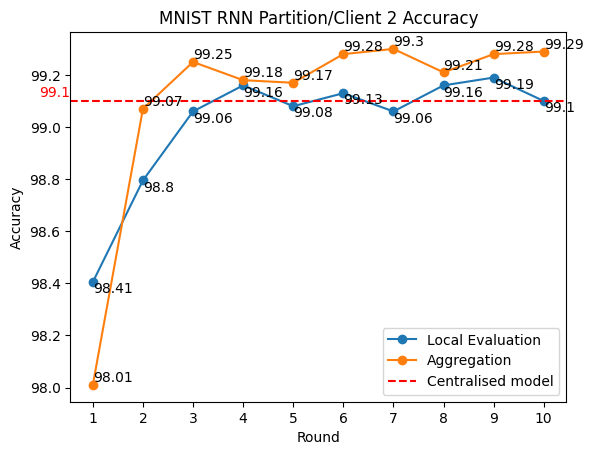

In [18]:
#plt.plot(iteration,Train_acc_result,marker='o',label="Train")
plt.title(f"MNIST RNN Partition/Client {NumOfPartition} Accuracy")
plt.plot(iteration,Val_acc_result,marker='o',label="Local Evaluation")
plt.plot(iteration,Test_acc_result,marker='o',label="Aggregation")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.xticks(iteration)

for i, j in zip(iteration, Val_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='top')
for i, j in zip(iteration, Test_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')#plt.savefig(f"MNIST_RNN_Partition_Client_{NumOfPartition}_Accuracy.png")

average_value = 99.1
plt.gca().text(0, average_value/120, f"{average_value}", transform=plt.gca().transAxes, ha='right',color='r',)
plt.axhline(y=average_value, color='r', linestyle='--', label='Centralised model')

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.legend()

plt.show()